In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="2"

Running Scanpy 1.6.0, on 2021-04-14 17:46.


In [7]:
# adata1 = sc.read_text('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b1_exprs.txt').T
# info1 = pd.read_csv('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b1_celltype.txt', sep='\t', index_col=0)
# adata1.obs['celltype'] = info1.CellType

# adata2 = sc.read_text('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b2_exprs.txt').T
# info2 = pd.read_csv('../github_code/Batch-effect-removal-benchmarking/Data/dataset5/b2_celltype.txt', sep='\t', index_col=0)
# adata2.obs['celltype'] = info2.CellType

# adata = adata1.concatenate(adata2)

# adata.write_h5ad('data/dataset5.h5ad')

... storing 'celltype' as categorical


In [2]:
adata = sc.read_h5ad('data/dataset5.h5ad')

adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:01:11): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:22)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


In [3]:
batch_names = adata.obs['batch'].value_counts().index.values
adatas = [adata[adata.obs['batch'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata)
entropy_raw=compute_entropy(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


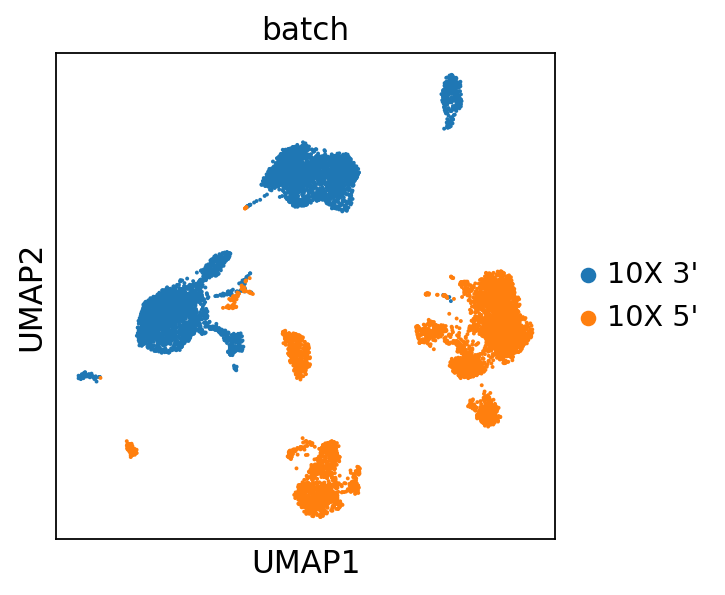

In [5]:
adata.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata.obs['batch']]
sc.pl.umap(adata,color='batch',save='_figure4_raw_batch.pdf')

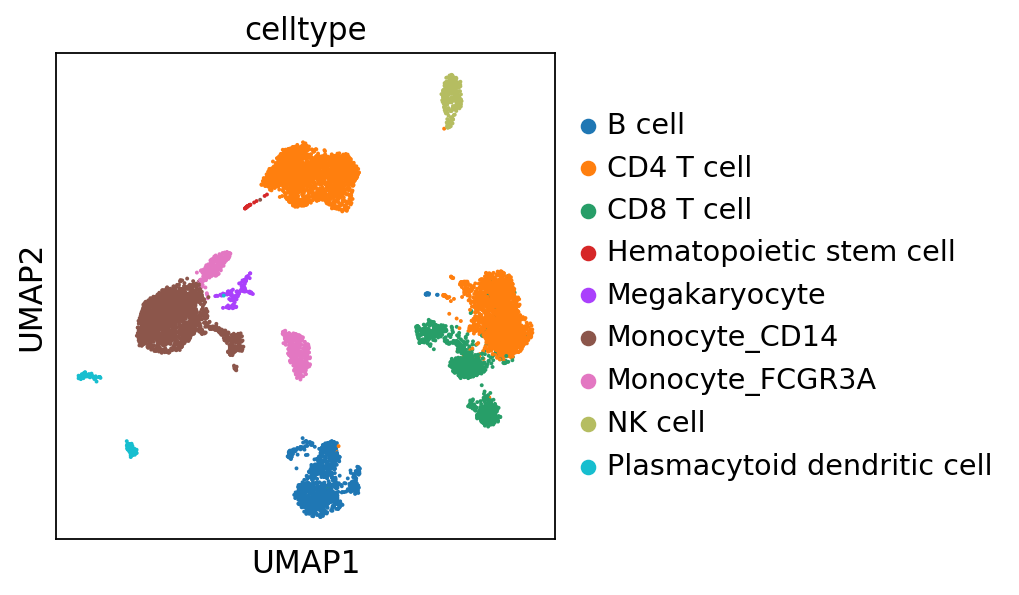

In [6]:
sc.pl.umap(adata,color='celltype',save='_figure4_raw_celltype.pdf')

# Batch correction using deepMNN

In [7]:
time_s = time.time()
corrected = correct_scanpy(adatas)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result)
entropy_deepMNN=compute_entropy(adata_result)

[[0.         0.42587601]
 [0.         0.        ]]
Epoch 0, loss: 1375.691, counter: 0
Learning rate = 0.1000000
Epoch 1, loss: 1049.937, counter: 0
Learning rate = 0.1000000
Epoch 2, loss: 992.782, counter: 0
Learning rate = 0.1000000
Epoch 3, loss: 930.343, counter: 0
Learning rate = 0.1000000
Epoch 4, loss: 837.183, counter: 0
Learning rate = 0.1000000
Epoch 5, loss: 713.589, counter: 0
Learning rate = 0.1000000
Epoch 6, loss: 571.080, counter: 0
Learning rate = 0.1000000
Epoch 7, loss: 437.647, counter: 0
Learning rate = 0.1000000
Epoch 8, loss: 334.946, counter: 0
Learning rate = 0.1000000
Epoch 9, loss: 256.819, counter: 0
Learning rate = 0.1000000
Epoch 10, loss: 201.992, counter: 0
Learning rate = 0.1000000
Epoch 11, loss: 174.331, counter: 0
Learning rate = 0.1000000
Epoch 12, loss: 148.126, counter: 0
Learning rate = 0.1000000
Epoch 13, loss: 141.425, counter: 0
Learning rate = 0.1000000
Epoch 14, loss: 131.524, counter: 0
Learning rate = 0.1000000
Epoch 15, loss: 115.956, co

... storing 'celltype' as categorical
... storing 'batch' as categorical


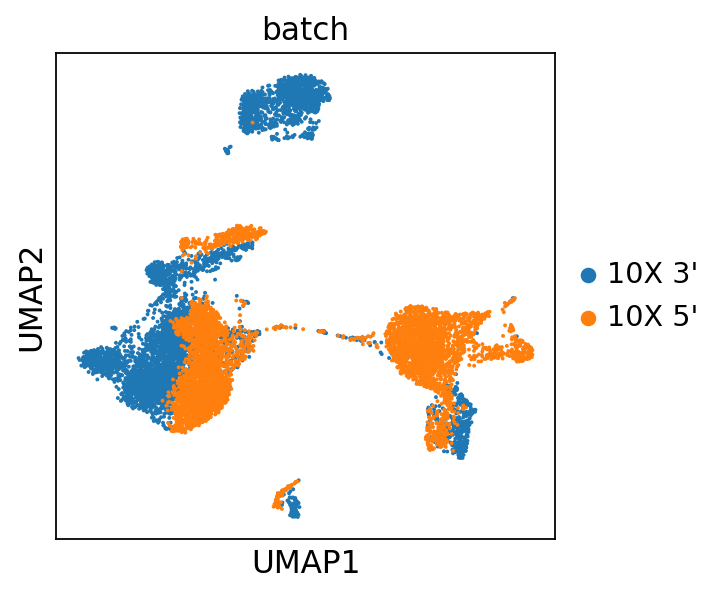

In [8]:
adata_result.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch']]
sc.pl.umap(adata_result,color='batch',save='_figure4_deepMNN_batch.pdf')

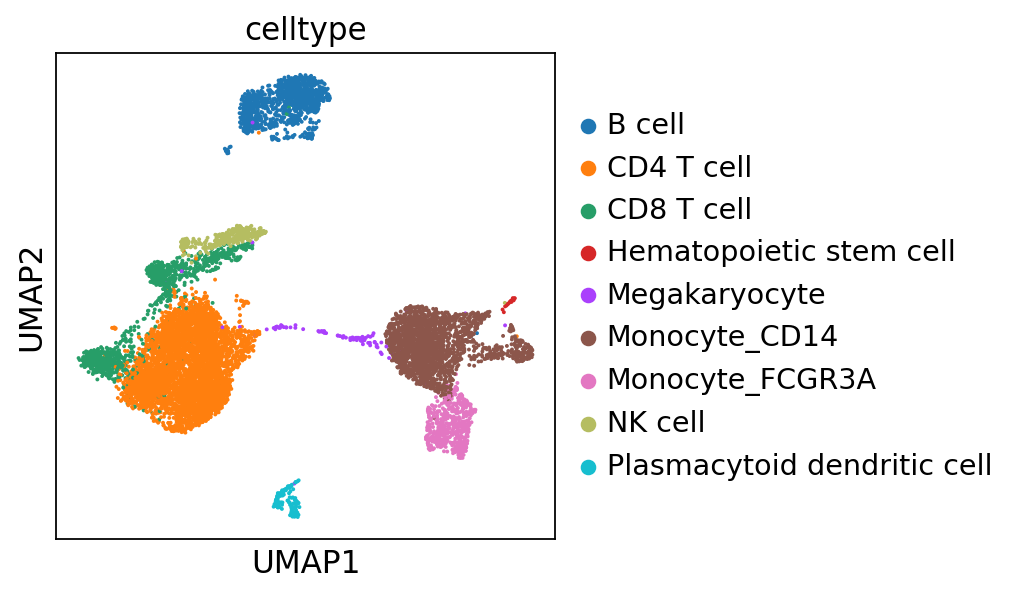

In [9]:
sc.pl.umap(adata_result,color='celltype',save='_figure4_deepMNN_celltype.pdf')

# Batch correction using Scanorama

In [10]:
import scanorama

adata = sc.read_h5ad('data/dataset5.h5ad')

adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:,adata.var['highly_variable']]

adatas = [adata[adata.obs['batch'] == i,:].copy() for i in ['0','1']]

time_s = time.time()
corrected = scanorama.correct_scanpy(adatas)
print('time used:', time.time()-time_s)

corrected_dataset = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(corrected_dataset, svd_solver='arpack')
sc.pp.neighbors(corrected_dataset)
sc.tl.umap(corrected_dataset)

asw_Scanorama = silhouette_coeff_ASW(corrected_dataset)
entropy_Scanorama=compute_entropy(corrected_dataset)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:16): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:21)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Found 1999 genes among all datasets
[[0.        0.4097035]
 [0.        0.       ]]
Processing datasets (0, 1)
time used: 14.383804559707642
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)
Calculating entropy ...
use exist neighbor

... storing 'celltype' as categorical
... storing 'batch' as categorical


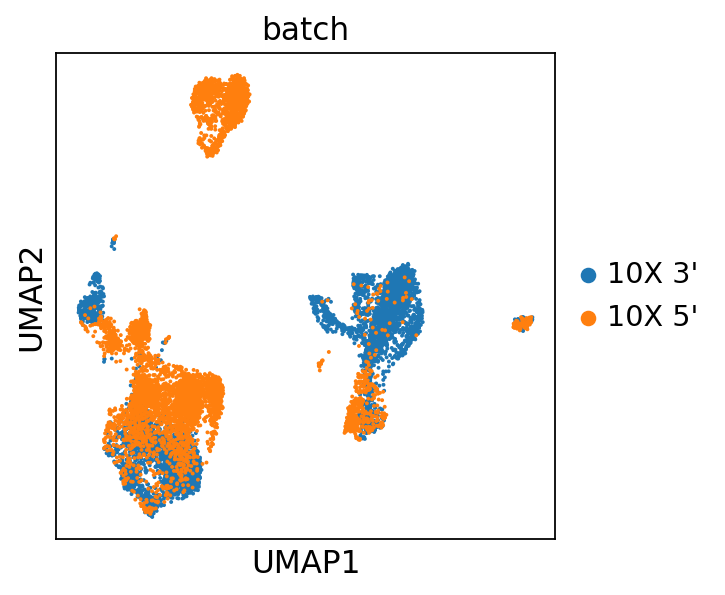

In [11]:
corrected_dataset.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in corrected_dataset.obs['batch']]
sc.pl.umap(corrected_dataset,color='batch',save='_figure4_Scanorama_batch.pdf')

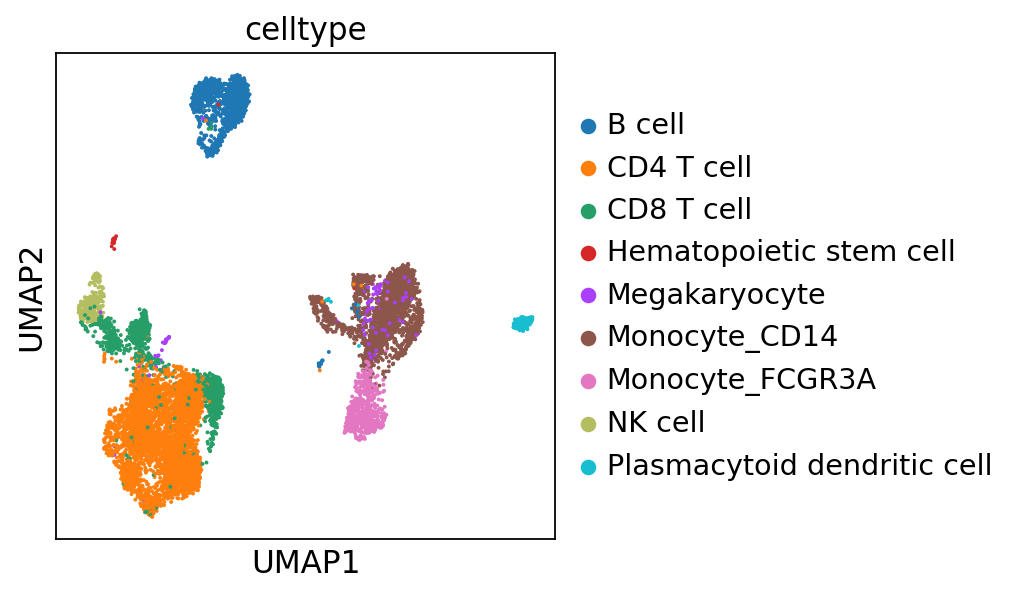

In [12]:
sc.pl.umap(corrected_dataset,color='celltype',save='_figure4_Scanorama_celltype.pdf')

# Metrics

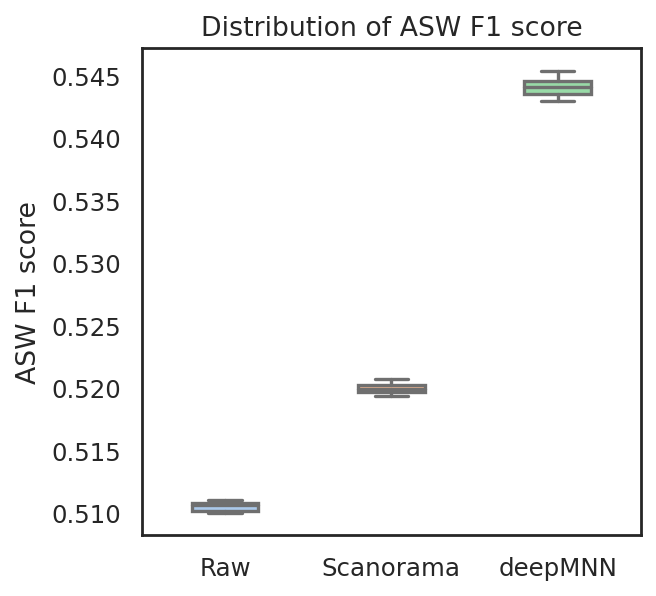

In [13]:
asw_df = pd.DataFrame()
asw_df['ASW F1 score'] = asw_raw['fscore'].tolist() + asw_Scanorama['fscore'].tolist() + asw_deepMNN['fscore'].tolist()
asw_df['Methods'] = (['Raw'] * asw_raw.shape[0] + 
                     ['Scanorama'] * asw_raw.shape[0] + 
                     ['deepMNN'] * asw_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette='pastel')
sns.boxplot(x='Methods', y='ASW F1 score', width=0.4, data=asw_df)
plt.title('Distribution of ASW F1 score')
plt.xlabel('')
plt.savefig('figures/ASW_F1_score_figure4.pdf', format='pdf', dpi=300, bbox_inches='tight')

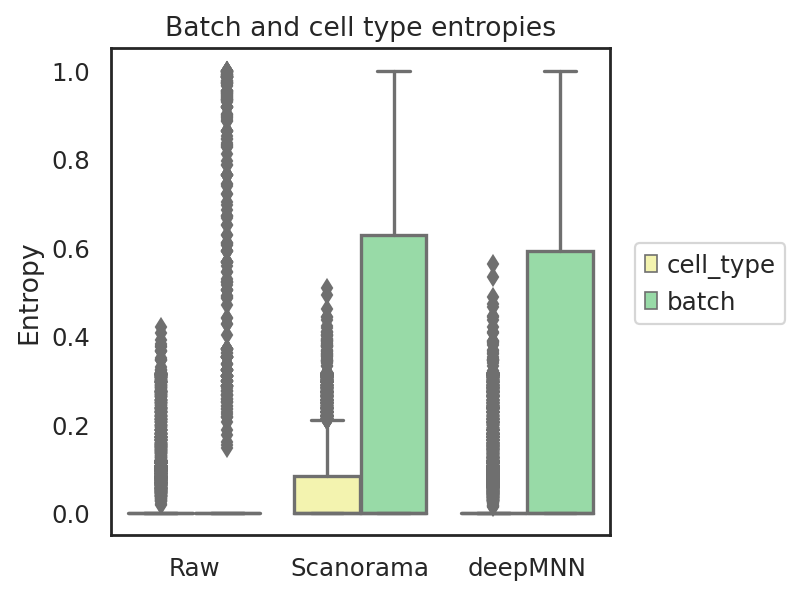

In [14]:
entropy_df = pd.DataFrame()
entropy_df['Entropy'] = (entropy_raw['cell_type'].tolist() + entropy_raw['batch'].tolist() + 
                         entropy_Scanorama['cell_type'].tolist() + entropy_Scanorama['batch'].tolist() + 
                         entropy_deepMNN['cell_type'].tolist() + entropy_deepMNN['batch'].tolist())
entropy_df['Methods'] = (['Raw'] * entropy_raw.shape[0] * 2 + 
                         ['Scanorama'] * entropy_raw.shape[0] * 2 + 
                         ['deepMNN'] * entropy_raw.shape[0] * 2)
entropy_df['Entropy_type'] = (['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette="pastel")

sns.boxplot(x='Methods', y='Entropy',
            hue='Entropy_type', palette=['y', 'g'], data=entropy_df)
plt.title('Batch and cell type entropies')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 0.6), borderaxespad=0)
plt.savefig('figures/Entropy_figure4.pdf', format='pdf', dpi=300, bbox_inches='tight')